In [92]:
import re
import dill
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from wordcloud import WordCloud

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, TfidfModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Path
folders = './final/'
file_url = folders + 'lematize_corpus.csv'

model_folders = './models/'
dest_dictionary = model_folders + 'gensim_dictionary.dict'
dest_corpus = model_folders + 'gensim_bow_corpus.mm'
dest_model = model_folders + 'gensim_model_dill.pkl'
dest_model_tfidf = model_folders + 'gensim_model_tfidf_dill.pkl'

gs_model_bk = './gs_models/gensim.model'

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Custom
%run -i ./python-code/helper.py
%run -i ./python-code/config.py
%run -i ./python-code/nlp_scripts.py

In [ ]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [12]:
frame = pd.read_csv(file_url, sep='|', encoding="utf-8")
frame.head()

,text,list_text,lemma_text
0,People with an irregular heart beat condition...,"['people', 'with', 'an', 'irregular', 'heart',...",people irregular heart beat condition should b...
1,Politicians in the Catholic Republic of Irelan...,"['politicians', 'in', 'the', 'catholic', 'repu...",politician catholic republic ireland have over...
2,In the winter months temperatures and humidity...,"['in', 'the', 'winter', 'months', 'temperature...",winter month temperature humidity level plumme...
3,A system of special measures designed to impro...,"['system', 'of', 'special', 'measures', 'desig...",system special measure design improve fail hos...
4,A can be hard enough to get on your own Add in...,"['can', 'be', 'hard', 'enough', 'to', 'get', '...",can be hard enough get own add challenge sleep...


In [13]:
frame = frame[pd.notnull(frame['lemma_text'])]
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25729 entries, 0 to 25728
Data columns (total 3 columns):
text          25729 non-null object
list_text     25729 non-null object
lemma_text    25729 non-null object
dtypes: object(3)
memory usage: 804.0+ KB


In [14]:
corpus = frame['lemma_text'].values

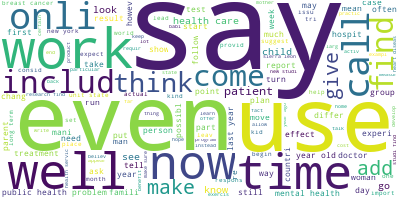

In [8]:
# Join the different processed title together.
long_string = ','.join(corpus)

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

### Data Preprocessing

In [22]:
# Preview a document after preprocessing
# --------------------------------------------------------------------------
# --------------------------------------------------------------------------
sample_id = 20
doc_sample = corpus[sample_id]

print("Original document: ")
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print("\n\nTokenized and lemmatized document: ")
print(preprocess(doc_sample))

Original document: 
['nurse', 'pauline', 'cafferkey', 'be', 'battle', 'london', 'hospital', 'could', 'be', 'offer', 'plasma', 'patient', 'have', 'survive', 'virus', 'treatment', 'contain', 'antibody', 'should', 'help', 'fight', 'infection', 'british', 'nurse', 'william', 'pooley', 'have', 'donate', 'plasma', 'chief', 'medical', 'officer', 'dame', 'sally', 'davie', 'confirm', 'other', 'available', 'treatment', 'include', 'antiviral', 'drug', 'there', 'be', 'stock', 'leave', 'zmapp', 'drug', 'use', 'treat', 'pooley', 'recover', 'september', 'be', 'treat', 'royal', 'free', 'hospital', 'hampstead', 'north', 'london', 'where', 'ms', 'cafferkey', 'be', 'currently', 'be', 'care', 'have', 'fight', 'infection', 'blood', 'should', 'help', 'other', 'do', 'same', 'dame', 'sally', 'say', 'would', 'be', 'ms', 'cafferkey', 'doctor', 'decide', 'treatment', 'use', 'add', 'cornerstone', 'treatment', 'remain', 'fluid', 'electrolyte', 'treatment', 'ms', 'cafferkey', 'be', 'diagnose', 'return', 'glasgow', 

In [18]:
processed_docs = []

for doc in corpus:
    processed_docs.append(preprocess(doc))
print(processed_docs[sample_id])

### Bag of words

In [19]:
# containing the number of times a word appears in the training set. 
# To do that, let's pass processed_docs to gensim.corpora.Dictionary() and call it 'dictionary'.

dictionary = gensim.corpora.Dictionary(processed_docs)


# Checking dictionary created
# --------------------------------------------------------------------------
# --------------------------------------------------------------------------
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 age
1 appropri
2 associ
3 atrial
4 author
5 away
6 base
7 beat
8 benefit
9 bleed
10 blood


In [20]:
# Filter out tokens that appear in:
# - words appearing less than 15 times
# - words appearing in more than 10% of all documents
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)

In [23]:
# Create the Bag-of-words model for each document 
# i.e for each document we create a dictionary reporting how many
# words and how many times those words appear. Save this to 'bow_corpus'
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]


# Preview BOW for our sample preprocessed document
# --------------------------------------------------------------------------
# --------------------------------------------------------------------------
bow_doc_x = bow_corpus[sample_id]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 4 ("bleed") appears 1 time.
Word 7 ("centr") appears 1 time.
Word 9 ("consult") appears 1 time.
Word 11 ("diagnos") appears 1 time.
Word 54 ("martin") appears 1 time.
Word 123 ("kill") appears 1 time.
Word 165 ("review") appears 1 time.
Word 166 ("room") appears 1 time.
Word 182 ("surviv") appears 1 time.
Word 185 ("temperatur") appears 2 time.
Word 223 ("extern") appears 1 time.
Word 225 ("failur") appears 1 time.
Word 276 ("advis") appears 1 time.
Word 302 ("check") appears 2 time.
Word 312 ("contact") appears 3 time.
Word 346 ("fatigu") appears 1 time.
Word 403 ("outsid") appears 1 time.
Word 407 ("pass") appears 1 time.
Word 437 ("screen") appears 3 time.
Word 470 ("tend") appears 1 time.
Word 509 ("circumst") appears 1 time.
Word 533 ("glasgow") appears 3 time.
Word 552 ("scotland") appears 1 time.
Word 617 ("fight") appears 2 time.
Word 641 ("muscl") appears 1 time.
Word 697 ("british") appears 1 time.
Word 704 ("london") appears 2 time.
Word 752 ("decid") appears 1 time.
Wo

In [48]:
print(dictionary)

Dictionary(11074 unique tokens: ['age', 'appropri', 'atrial', 'beat', 'bleed']...)


### Fitting with LDA model

In [43]:
# Train your lda model using gensim.models.LdaMulticore and save it to 'lda_model'
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = E_TOPICS, 
                                   id2word = dictionary,  
                                   random_state=100,
                                   passes = 10,
                                   workers = 2)

doc_lda = lda_model[bow_corpus]
print(doc_lda)

Process ForkPoolWorker-21:
Process ForkPoolWorker-20:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/shaynenguyen2012/anaconda3/envs/caps_env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shaynenguyen2012/anaconda3/envs/caps_env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shaynenguyen2012/anaconda3/envs/caps_env/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shaynenguyen2012/anaconda3/envs/caps_env/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shaynenguyen2012/anaconda3/envs/caps_env/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "/home/shaynenguyen2012/anaconda3/envs/caps_env/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs

KeyboardInterrupt: 

  File "/home/shaynenguyen2012/anaconda3/envs/caps_env/lib/python3.6/site-packages/gensim/models/ldamodel.py", line 495, in inference
    gammad = self.alpha + expElogthetad * np.dot(cts / phinorm, expElogbetad.T)
KeyboardInterrupt
KeyboardInterrupt


In [49]:
# Compute Perplexity
# --------------------------------------------------------------------------
# --------------------------------------------------------------------------
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
# --------------------------------------------------------------------------
# --------------------------------------------------------------------------
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.882484054959185

Coherence Score:  0.5801929270672801


In [24]:
# Preview each topic & explore the words occuring and its relative weight
# --------------------------------------------------------------------------
# --------------------------------------------------------------------------
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {} \n".format(idx, topic ))

Topic: 0 
Words: 0.007*"sleep" + 0.006*"pain" + 0.005*"stress" + 0.004*"depress" + 0.004*"disord" + 0.003*"behavior" + 0.003*"stroke" + 0.003*"mother" + 0.003*"loss" + 0.003*"memori" 

Topic: 1 
Words: 0.014*"outbreak" + 0.012*"smoke" + 0.011*"alcohol" + 0.009*"cigarett" + 0.009*"drink" + 0.008*"west" + 0.008*"africa" + 0.007*"liberia" + 0.006*"sierra" + 0.006*"contact" 

Topic: 2 
Words: 0.013*"insur" + 0.010*"obes" + 0.008*"feder" + 0.006*"coverag" + 0.006*"birth" + 0.005*"polici" + 0.005*"diabet" + 0.005*"market" + 0.004*"administr" + 0.004*"incom" 

Topic: 3 
Words: 0.018*"vaccin" + 0.012*"cell" + 0.006*"skin" + 0.006*"immun" + 0.005*"bacteria" + 0.005*"genet" + 0.005*"water" + 0.005*"anim" + 0.004*"antibiot" + 0.004*"foot" 

Topic: 4 
Words: 0.008*"mental" + 0.006*"breast" + 0.006*"trust" + 0.004*"money" + 0.004*"qualiti" + 0.003*"surgeri" + 0.003*"profession" + 0.003*"access" + 0.003*"board" + 0.003*"save" 

Topic: 5 
Words: 0.020*"calori" + 0.014*"diet" + 0.014*"sugar" + 0.010*"

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
vis

In [25]:
unseem_data = '''
Ultra-processed foods - such as chicken nuggets, ice cream and breakfast cereals - have been linked to early death and poor health, scientists say. 
Researchers in France and Spain say the amount of such food being eaten has soared.
Their studies are not definite proof of harm but do come hot on the heels of trials suggesting ultra-processed foods 
.
Experts expressed caution but called for further investigation. 
The term comes from a way of classifying food by how much industrial processing it has been through.
The lowest category is "unprocessed or minimally processed foods", which include: • fruit • vegetables • milk • meat • legumes such as lentils • seeds • grains such as rice • eggs
"Processed foods" have been altered to make them last longer or taste better - generally using salt, oil, sugar or fermentation.
This category includes: • cheese • bacon • home-made bread • tinned fruit and vegetables • smoked fish • beer
Then come "ultra-processed foods", which have been through more substantial industrial processing and often have long ingredient lists on the packet, including added preservatives, sweeteners or colour enhancers. 
If a product contains more than five ingredients, it is probably ultra-processed, says Prof Maira Bes-Rastrollo, of the University of Navarra, citing a maxim.
Examples include: • processed meat such as sausages and hamburgers • breakfast cereals or cereal bars • instant soups • sugary fizzy drinks • chicken nuggets • cake • chocolate • ice cream • mass-produced bread • many "ready to heat" meals such as pies and pizza | meal-replacement shakes 
, by the University of Navarra, in Spain, followed 19,899 people for a decade and assessed their diet every other year. There were 335 deaths during the study.
But for every 10 deaths among those eating the least ultra-processed food, there were 16 deaths among those eating the most (more than four portions a day).
, by the University of Paris, followed 105,159 people for five years and assessed their diet twice a year.
It showed those eating more ultra-processed food had worse heart health. 
Rates of cardiovascular disease were 277 per 100,000 people per year among those eating the most ultra-processed food, compared with 242 per 100,000 among those eating the least. 
The rapid increase of ultra-processed foods over less processed foods, "may drive a substantial burden of cardiovascular diseases in the next decades," said Dr Mathilde Touvier, of the University of Paris.
"[The] evidence is accumulating," said Dr Touvier, noting "increasing numbers of independent studies". Prof Bes-Rastrollo said she was "very certain" ultra-processed foods were bad for health.
Last year, a link was made with 
.
The challenge is being 100% sure. The studies have spotted a pattern between highly processed food and poor health but they cannot prove that one causes the other. 
Those who ate the most ultra-processed food were also more likely to have other unhealthy behaviours, such as smoking, which the researchers tried to account for. 
But there's no guarantee everything relevant was covered, says Kevin McConway, a professor of statistics at The Open University.
"These studies do increase my confidence that there's something real behind these associations - but I'm still far from sure."
The first trial of ultra-processed foods showed they led people to eat more and put on weight. 
Researchers at the US National Institutes of Health monitored every morsel of food that volunteers ate for a month.
And when given ultra-processed food, they ate 500 calories a day more than when they were given unprocessed meals.
Other suggestions include: 
These ideas still need researching.
While the term ultra-processed food may be new, the health advice will be very familiar: adopt a Mediterranean-style diet.
Such a diet includes plenty of minimally or unprocessed foods, such as fruit, vegetables, fish, nuts and seeds, beans, lentils and wholegrains, said Victoria Taylor, senior dietician at the British Heart Foundation.
"This, along with exercising regularly and not smoking, has been shown to be beneficial for lowering risk of heart and circulatory disease."
Measures such as taxation and marketing restrictions on ultra-processed foods, should be considered, said Prof Bes-Rastrollo, given the weight of evidence. 
There are certainly a lot of critics. 
The labelling of food as ultra-processed could be inconsistent, said Dr Gunter Kuhnle, an expert in nutrition and health at the University of Reading
"It is also not obvious why salami is considered to be ultra-processed, yet cheese, which often requires considerably more processing steps and additives, is not.  The classification combines a wide range of foods with very different potential impacts on health, which limits its usefulness as a basis for recommendations."
The studies were published in the British Medical Journal.
'''

In [28]:
# Data preprocessing step for the unseen document
bow_vector = dictionary.doc2bow(preprocess(unseem_data))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))


Score: 0.5723659992218018	 Topic: 0.020*"calori" + 0.014*"diet" + 0.014*"sugar" + 0.010*"drink" + 0.009*"protein"
Score: 0.22070960700511932	 Topic: 0.007*"sleep" + 0.006*"pain" + 0.005*"stress" + 0.004*"depress" + 0.004*"disord"
Score: 0.10423325002193451	 Topic: 0.008*"mental" + 0.006*"breast" + 0.006*"trust" + 0.004*"money" + 0.004*"qualiti"
Score: 0.05546845868229866	 Topic: 0.013*"insur" + 0.010*"obes" + 0.008*"feder" + 0.006*"coverag" + 0.006*"birth"
Score: 0.04643414542078972	 Topic: 0.014*"outbreak" + 0.012*"smoke" + 0.011*"alcohol" + 0.009*"cigarett" + 0.009*"drink"


### Tfidf Model

In [33]:
tfidf_model = TfidfModel(bow_corpus)
corpus_tfidf = tfidf_model[bow_corpus]

# Print-out corpus with itidf
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.062059789654421944),
 (1, 0.05103596051230517),
 (2, 0.21672917421947233),
 (3, 0.06151371343632531),
 (4, 0.06332202501721441),
 (5, 0.046557352195718445),
 (6, 0.04919657501739766),
 (7, 0.04403260895705322),
 (8, 0.07819946923153491),
 (9, 0.043728886829527185),
 (10, 0.053242395736833294),
 (11, 0.039970014981885134),
 (12, 0.06407990071132956),
 (13, 0.04992365664415114),
 (14, 0.11318552194375418),
 (15, 0.041712853463306686),
 (16, 0.049050003911182326),
 (17, 0.05347831502009148),
 (18, 0.08989936192559504),
 (19, 0.21590158371190052),
 (20, 0.04777427029039294),
 (21, 0.08363155771911633),
 (22, 0.30306112184597855),
 (23, 0.07630279670880089),
 (24, 0.11998024796542929),
 (25, 0.13102756678321895),
 (26, 0.054950844621024286),
 (27, 0.0686052748625486),
 (28, 0.05338354837934296),
 (29, 0.06093536542272357),
 (30, 0.05656534181849065),
 (31, 0.07510956282898516),
 (32, 0.039001162402043536),
 (33, 0.10419119277329551),
 (34, 0.10670415643478708),
 (35, 0.04309480055708

In [34]:
# Train your lda model using gensim.models.LdaMulticore and save it to 'lda_model_tfidf'
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, 
                                   num_topics = E_TOPICS, 
                                   id2word = dictionary,  
                                   random_state=100,
                                   passes = 10,
                                   workers = 2)


# Preview each topic & explore the words occuring and its relative weight
# --------------------------------------------------------------------------
# --------------------------------------------------------------------------
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}\n'.format(idx, topic))

Topic: 0 Word: 0.015*"cigarett" + 0.013*"smoke" + 0.009*"tobacco" + 0.006*"smoker" + 0.006*"skin" + 0.005*"allergi" + 0.005*"tooth" + 0.004*"bacteria" + 0.004*"nicotin" + 0.004*"water"

Topic: 1 Word: 0.028*"insur" + 0.016*"coverag" + 0.011*"exchang" + 0.010*"medicar" + 0.009*"enrol" + 0.009*"afford" + 0.009*"feder" + 0.009*"obama" + 0.008*"medicaid" + 0.006*"premium"

Topic: 2 Word: 0.007*"calori" + 0.004*"diet" + 0.004*"sugar" + 0.003*"fruit" + 0.003*"meal" + 0.003*"veget" + 0.003*"protein" + 0.002*"pound" + 0.002*"recip" + 0.002*"drink"

Topic: 3 Word: 0.012*"vaccin" + 0.008*"outbreak" + 0.005*"africa" + 0.005*"liberia" + 0.004*"west" + 0.004*"sierra" + 0.004*"leon" + 0.003*"guinea" + 0.003*"travel" + 0.003*"measl"

Topic: 4 Word: 0.004*"obes" + 0.003*"sleep" + 0.003*"cell" + 0.003*"breast" + 0.003*"diabet" + 0.003*"babi" + 0.003*"depress" + 0.002*"birth" + 0.002*"surgeri" + 0.002*"screen"

Topic: 5 Word: 0.004*"mental" + 0.003*"trust" + 0.002*"money" + 0.002*"organis" + 0.002*"acce

In [50]:
# Compute Perplexity
# --------------------------------------------------------------------------
# --------------------------------------------------------------------------
print('\nPerplexity: ', lda_model_tfidf.log_perplexity(corpus_tfidf))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
# --------------------------------------------------------------------------
# --------------------------------------------------------------------------
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.159308369426649

Coherence Score:  0.6127723681824775


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary)
vis

In [53]:
# Data preprocessing step for the unseen document
bow_vector = dictionary.doc2bow(preprocess(unseem_data))

for index, score in sorted(lda_model_tfidf[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.6719990372657776	 Topic: 0.019*"calori" + 0.010*"diet" + 0.010*"sugar" + 0.008*"protein" + 0.007*"fruit"
Score: 0.21588662266731262	 Topic: 0.009*"obes" + 0.009*"sleep" + 0.008*"drink" + 0.007*"diabet" + 0.007*"breast"
Score: 0.07653582096099854	 Topic: 0.006*"mental" + 0.005*"trust" + 0.003*"money" + 0.003*"room" + 0.003*"love"
Score: 0.03400932624936104	 Topic: 0.012*"cell" + 0.009*"smoke" + 0.008*"pain" + 0.007*"cigarett" + 0.007*"skin"


### Fitting with LSI model

In [59]:
# Train your lda model using gensim.models.LdaMulticore and save it to 'lda_model_tfidf'
lsi_model_tfidf = gensim.models.LsiModel(bow_corpus, 
                                   num_topics = E_TOPICS, 
                                   id2word = dictionary)

# Preview each topic & explore the words occuring and its relative weight
# --------------------------------------------------------------------------
# --------------------------------------------------------------------------
for idx, topic in lsi_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}\n'.format(idx, topic))

Topic: 0 Word: 0.405*"calori" + 0.193*"gram" + 0.181*"protein" + 0.180*"sugar" + 0.177*"chicken" + 0.164*"serv" + 0.144*"fiber" + 0.135*"fresh" + 0.128*"salt" + 0.126*"pepper"

Topic: 1 Word: 0.246*"vaccin" + -0.188*"calori" + -0.136*"chicken" + 0.128*"sleep" + -0.116*"gram" + 0.113*"mental" + 0.107*"pain" + 0.105*"insur" + 0.102*"cell" + -0.099*"pepper"

Topic: 2 Word: 0.441*"calori" + -0.415*"chicken" + -0.334*"vaccin" + -0.221*"breast" + -0.189*"fresh" + -0.185*"pepper" + -0.166*"oliv" + 0.161*"sugar" + 0.160*"drink" + 0.129*"gram"

Topic: 3 Word: -0.812*"vaccin" + -0.236*"calori" + 0.150*"chicken" + 0.131*"breast" + 0.119*"sleep" + -0.116*"outbreak" + -0.104*"immun" + -0.100*"measl" + -0.093*"gram" + 0.076*"mental"

Topic: 4 Word: 0.622*"sleep" + -0.278*"smoke" + -0.269*"cigarett" + 0.224*"hair" + -0.201*"drink" + -0.175*"insur" + -0.165*"alcohol" + 0.153*"cell" + -0.137*"tobacco" + 0.128*"night"

Topic: 5 Word: 0.530*"drink" + 0.421*"alcohol" + 0.366*"sleep" + -0.210*"insur" + 0.1

In [61]:
# Compute Perplexity
# --------------------------------------------------------------------------
# --------------------------------------------------------------------------
# print('\nPerplexity: ', lsi_model_tfidf.log_perplexity(corpus_tfidf))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
# --------------------------------------------------------------------------
# --------------------------------------------------------------------------
coherence_model_lda = CoherenceModel(model=lsi_model_tfidf, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4993860852635694


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lsi_model_tfidf, corpus_tfidf, dictionary)
vis

In [62]:
# Data preprocessing step for the unseen document
bow_vector = dictionary.doc2bow(preprocess(unseem_data))

for index, score in sorted(lsi_model_tfidf[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 4.957164451780165	 Topic: 0.012*"cell" + 0.009*"smoke" + 0.008*"pain" + 0.007*"cigarett" + 0.007*"skin"
Score: 1.22763498917826	 Topic: 0.006*"mental" + 0.005*"trust" + 0.003*"money" + 0.003*"room" + 0.003*"love"
Score: 0.8598863313481807	 Topic: 0.013*"insur" + 0.008*"feder" + 0.006*"coverag" + 0.006*"polici" + 0.005*"market"
Score: 0.5736175360366634	 Topic: 0.026*"vaccin" + 0.016*"outbreak" + 0.009*"africa" + 0.008*"west" + 0.007*"liberia"
Score: 0.4834207423493917	 Topic: 0.019*"calori" + 0.010*"diet" + 0.010*"sugar" + 0.008*"protein" + 0.007*"fruit"
Score: -1.4081592262645215	 Topic: 0.009*"obes" + 0.009*"sleep" + 0.008*"drink" + 0.007*"diabet" + 0.007*"breast"


### Visualization with LDA model

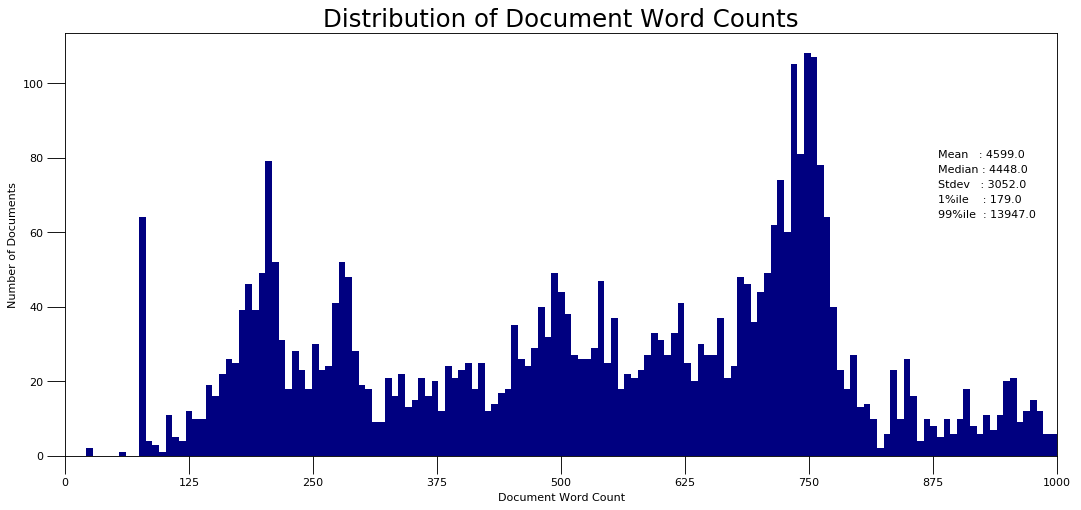

In [63]:
doc_lens = [len(d) for d in frame['list_text'].values]

# Plot
plt.figure(figsize=(16,7), dpi=80)
plt.hist(doc_lens, bins = 10000, color='navy')
plt.text(880, 80, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(880, 76, "Median : " + str(round(np.median(doc_lens))))
plt.text(880, 72, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(880, 68, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(880, 64, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [73]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=processed_docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=processed_docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.6948,"obes, sleep, drink, diabet, breast, alcohol, b...","[peopl, irregular, heart, beat, condit, close,..."
1,1,5.0,0.3923,"mental, trust, money, room, love, surgeri, qua...","[politician, cathol, republ, ireland, overwhel..."
2,2,0.0,0.9958,"cell, smoke, pain, cigarett, skin, bacteria, w...","[winter, month, temperatur, humid, level, plum..."
3,3,5.0,0.9924,"mental, trust, money, room, love, surgeri, qua...","[special, measur, design, improv, fail, hospit..."
4,4,4.0,0.6582,"obes, sleep, drink, diabet, breast, alcohol, b...","[hard, challeng, sleep, partner, snore, cover,..."
5,5,5.0,0.9002,"mental, trust, money, room, love, surgeri, qua...","[health, inspector, numer, problem, elder, pat..."
6,6,2.0,0.5895,"calori, diet, sugar, protein, fruit, meal, ser...","[belli, bulg, import, just, sake, excess, abdo..."
7,7,4.0,0.9826,"obes, sleep, drink, diabet, breast, alcohol, b...","[british, research, interview, mother, child, ..."
8,8,4.0,0.5349,"obes, sleep, drink, diabet, breast, alcohol, b...","[pollut, link, increas, risk, develop, irregul..."
9,9,2.0,0.5679,"calori, diet, sugar, protein, fruit, meal, ser...","[come, fee, littl, adult, know, good, nutritio..."


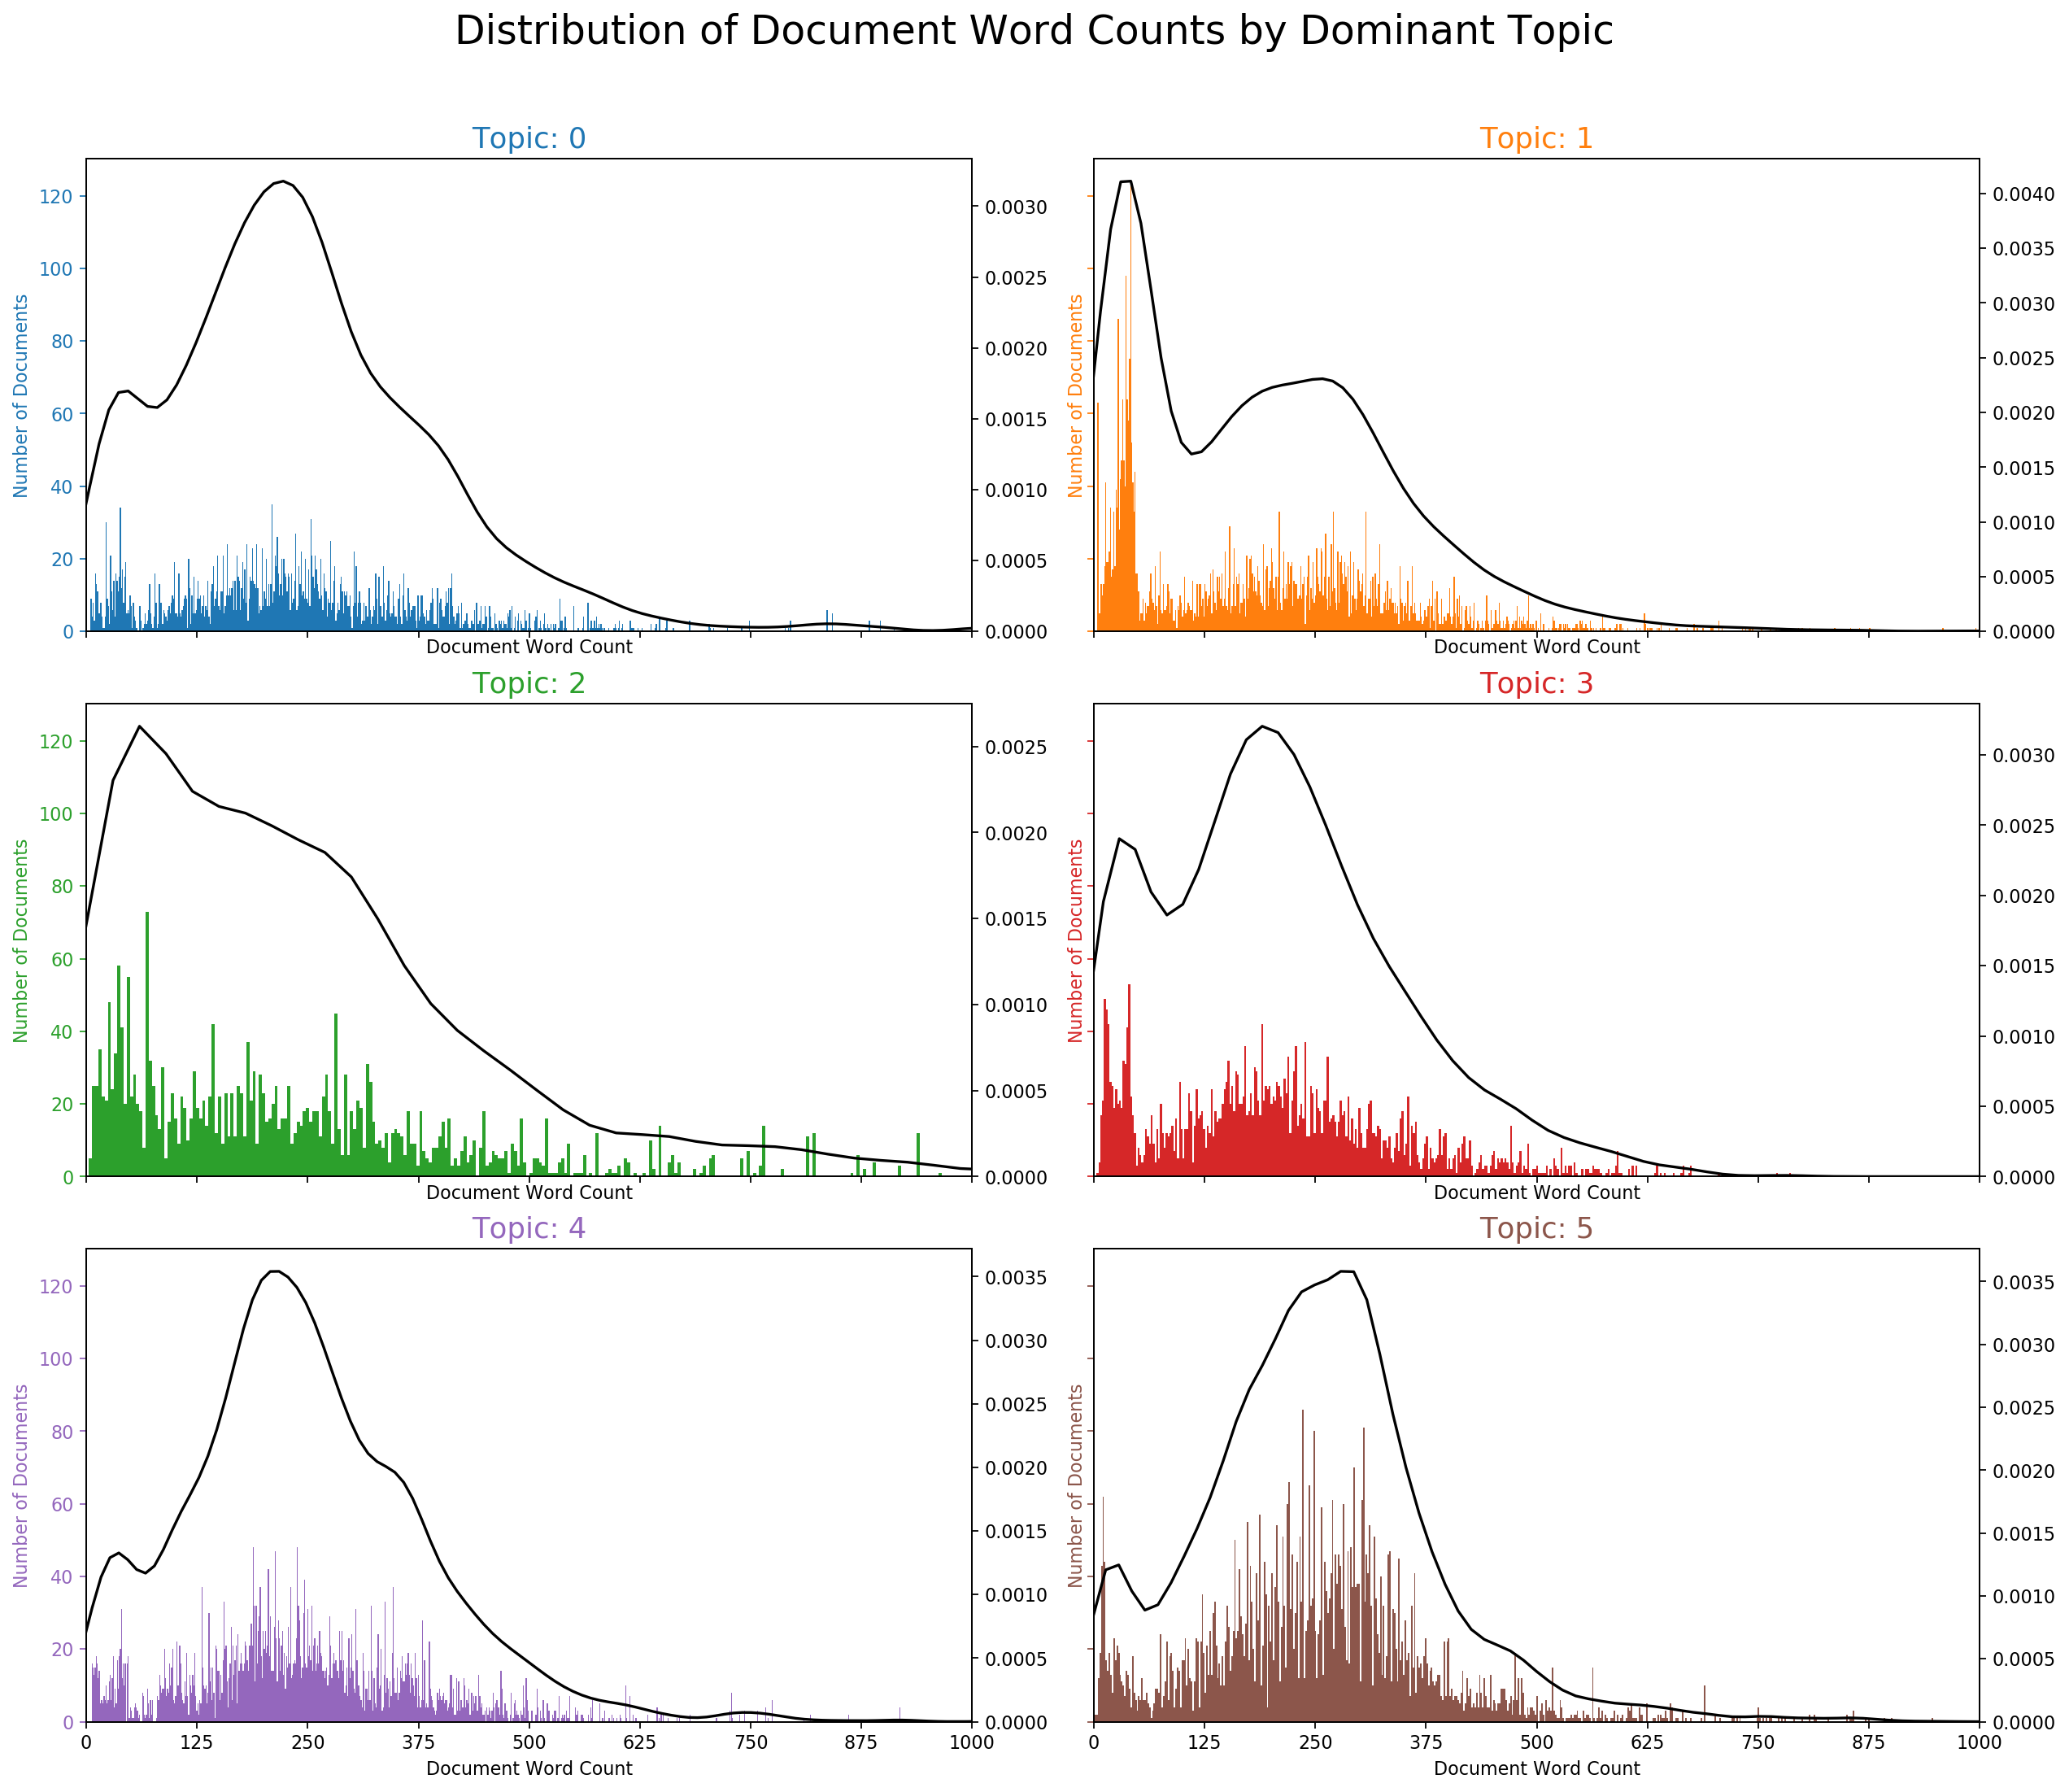

In [80]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

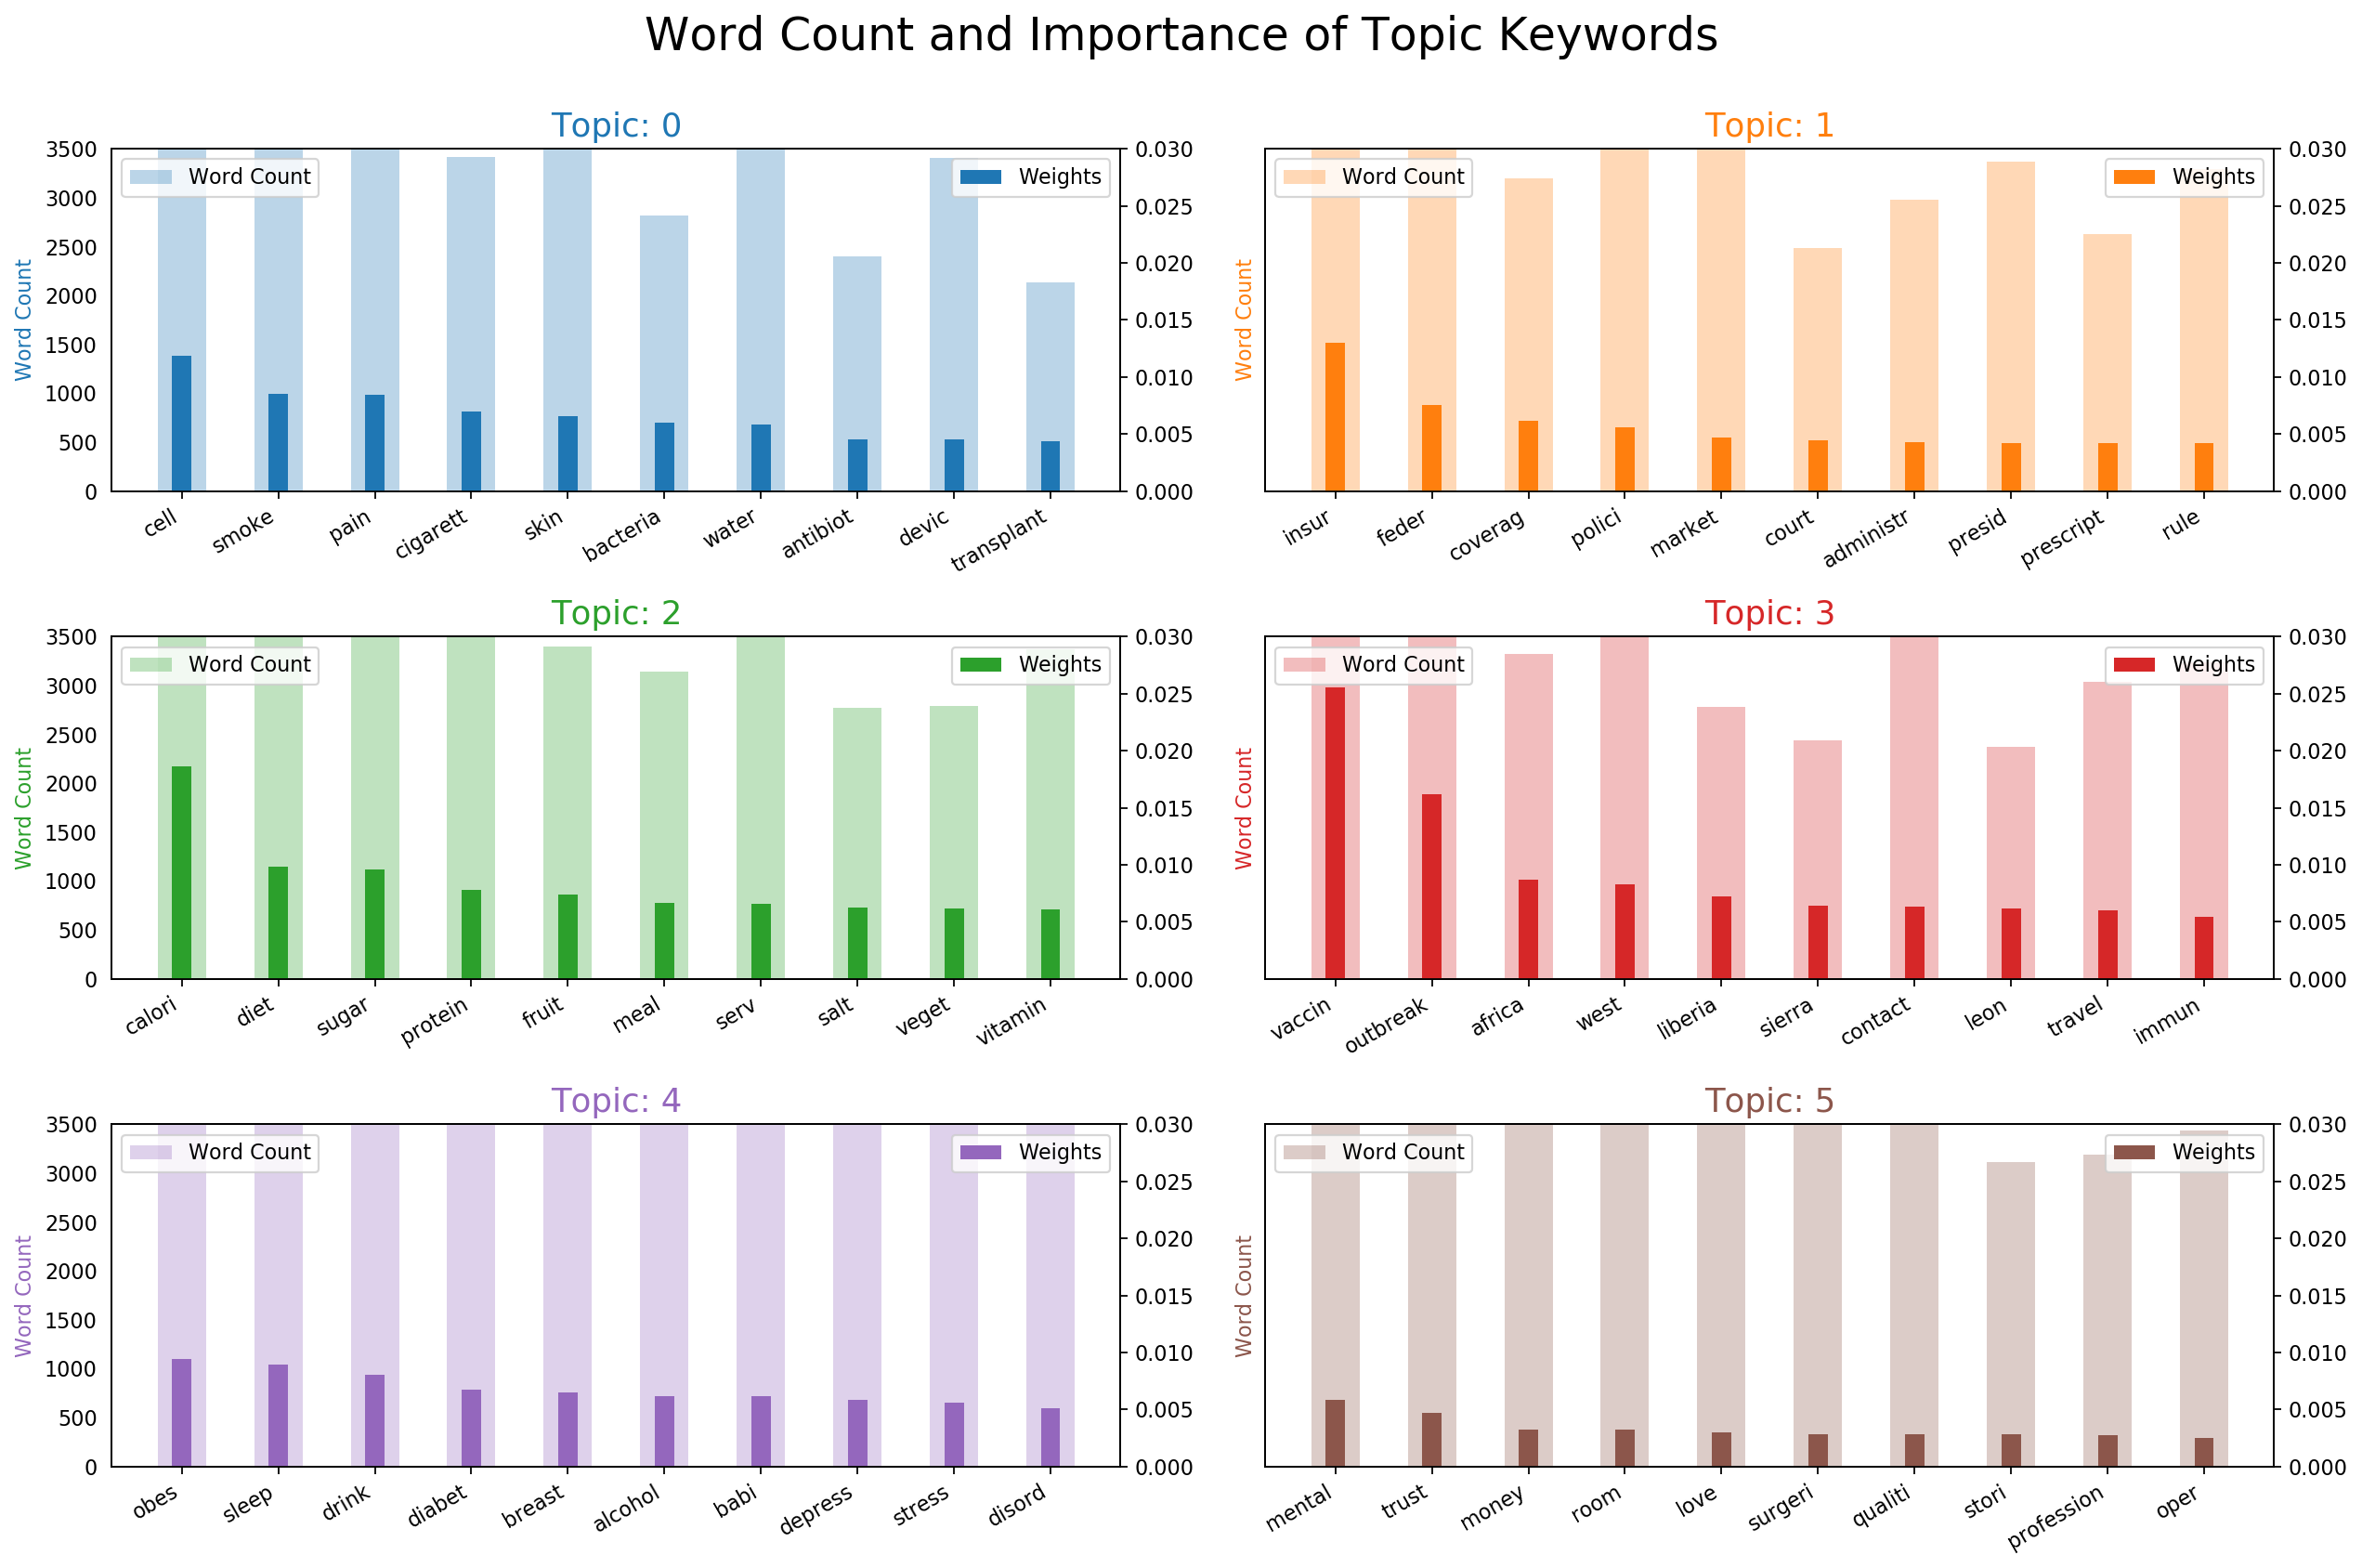

In [83]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in processed_docs for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [90]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[bow_corpus]):
    topic_weights.append([w for i, w in enumerate(row_list[0])])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(E_TOPICS), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 17540 samples in 0.065s...
[t-SNE] Computed neighbors for 17540 samples in 0.471s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17540
[t-SNE] Computed conditional probabilities for sample 2000 / 17540
[t-SNE] Computed conditional probabilities for sample 3000 / 17540
[t-SNE] Computed conditional probabilities for sample 4000 / 17540
[t-SNE] Computed conditional probabilities for sample 5000 / 17540
[t-SNE] Computed conditional probabilities for sample 6000 / 17540
[t-SNE] Computed conditional probabilities for sample 7000 / 17540
[t-SNE] Computed conditional probabilities for sample 8000 / 17540
[t-SNE] Computed conditional probabilities for sample 9000 / 17540
[t-SNE] Computed conditional probabilities for sample 10000 / 17540
[t-SNE] Computed conditional probabilities for sample 11000 / 17540
[t-SNE] Computed conditional probabilities for sample 12000 / 17540
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

### Visualization with LDA model

In [95]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_tfidf, corpus=corpus_tfidf, texts=processed_docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.8506,"obes, sleep, cell, breast, diabet, babi, depre...","[peopl, irregular, heart, beat, condit, close,..."
1,1,5.0,0.6297,"mental, trust, money, organis, access, board, ...","[politician, cathol, republ, ireland, overwhel..."
2,2,0.0,0.5937,"cigarett, smoke, tobacco, smoker, skin, allerg...","[winter, month, temperatur, humid, level, plum..."
3,3,5.0,0.9021,"mental, trust, money, organis, access, board, ...","[special, measur, design, improv, fail, hospit..."
4,4,2.0,0.9299,"calori, diet, sugar, fruit, meal, veget, prote...","[hard, challeng, sleep, partner, snore, cover,..."
5,5,5.0,0.8904,"mental, trust, money, organis, access, board, ...","[health, inspector, numer, problem, elder, pat..."
6,6,2.0,0.7049,"calori, diet, sugar, fruit, meal, veget, prote...","[belli, bulg, import, just, sake, excess, abdo..."
7,7,4.0,0.8117,"obes, sleep, cell, breast, diabet, babi, depre...","[british, research, interview, mother, child, ..."
8,8,4.0,0.6375,"obes, sleep, cell, breast, diabet, babi, depre...","[pollut, link, increas, risk, develop, irregul..."
9,9,2.0,0.8886,"calori, diet, sugar, fruit, meal, veget, prote...","[come, fee, littl, adult, know, good, nutritio..."


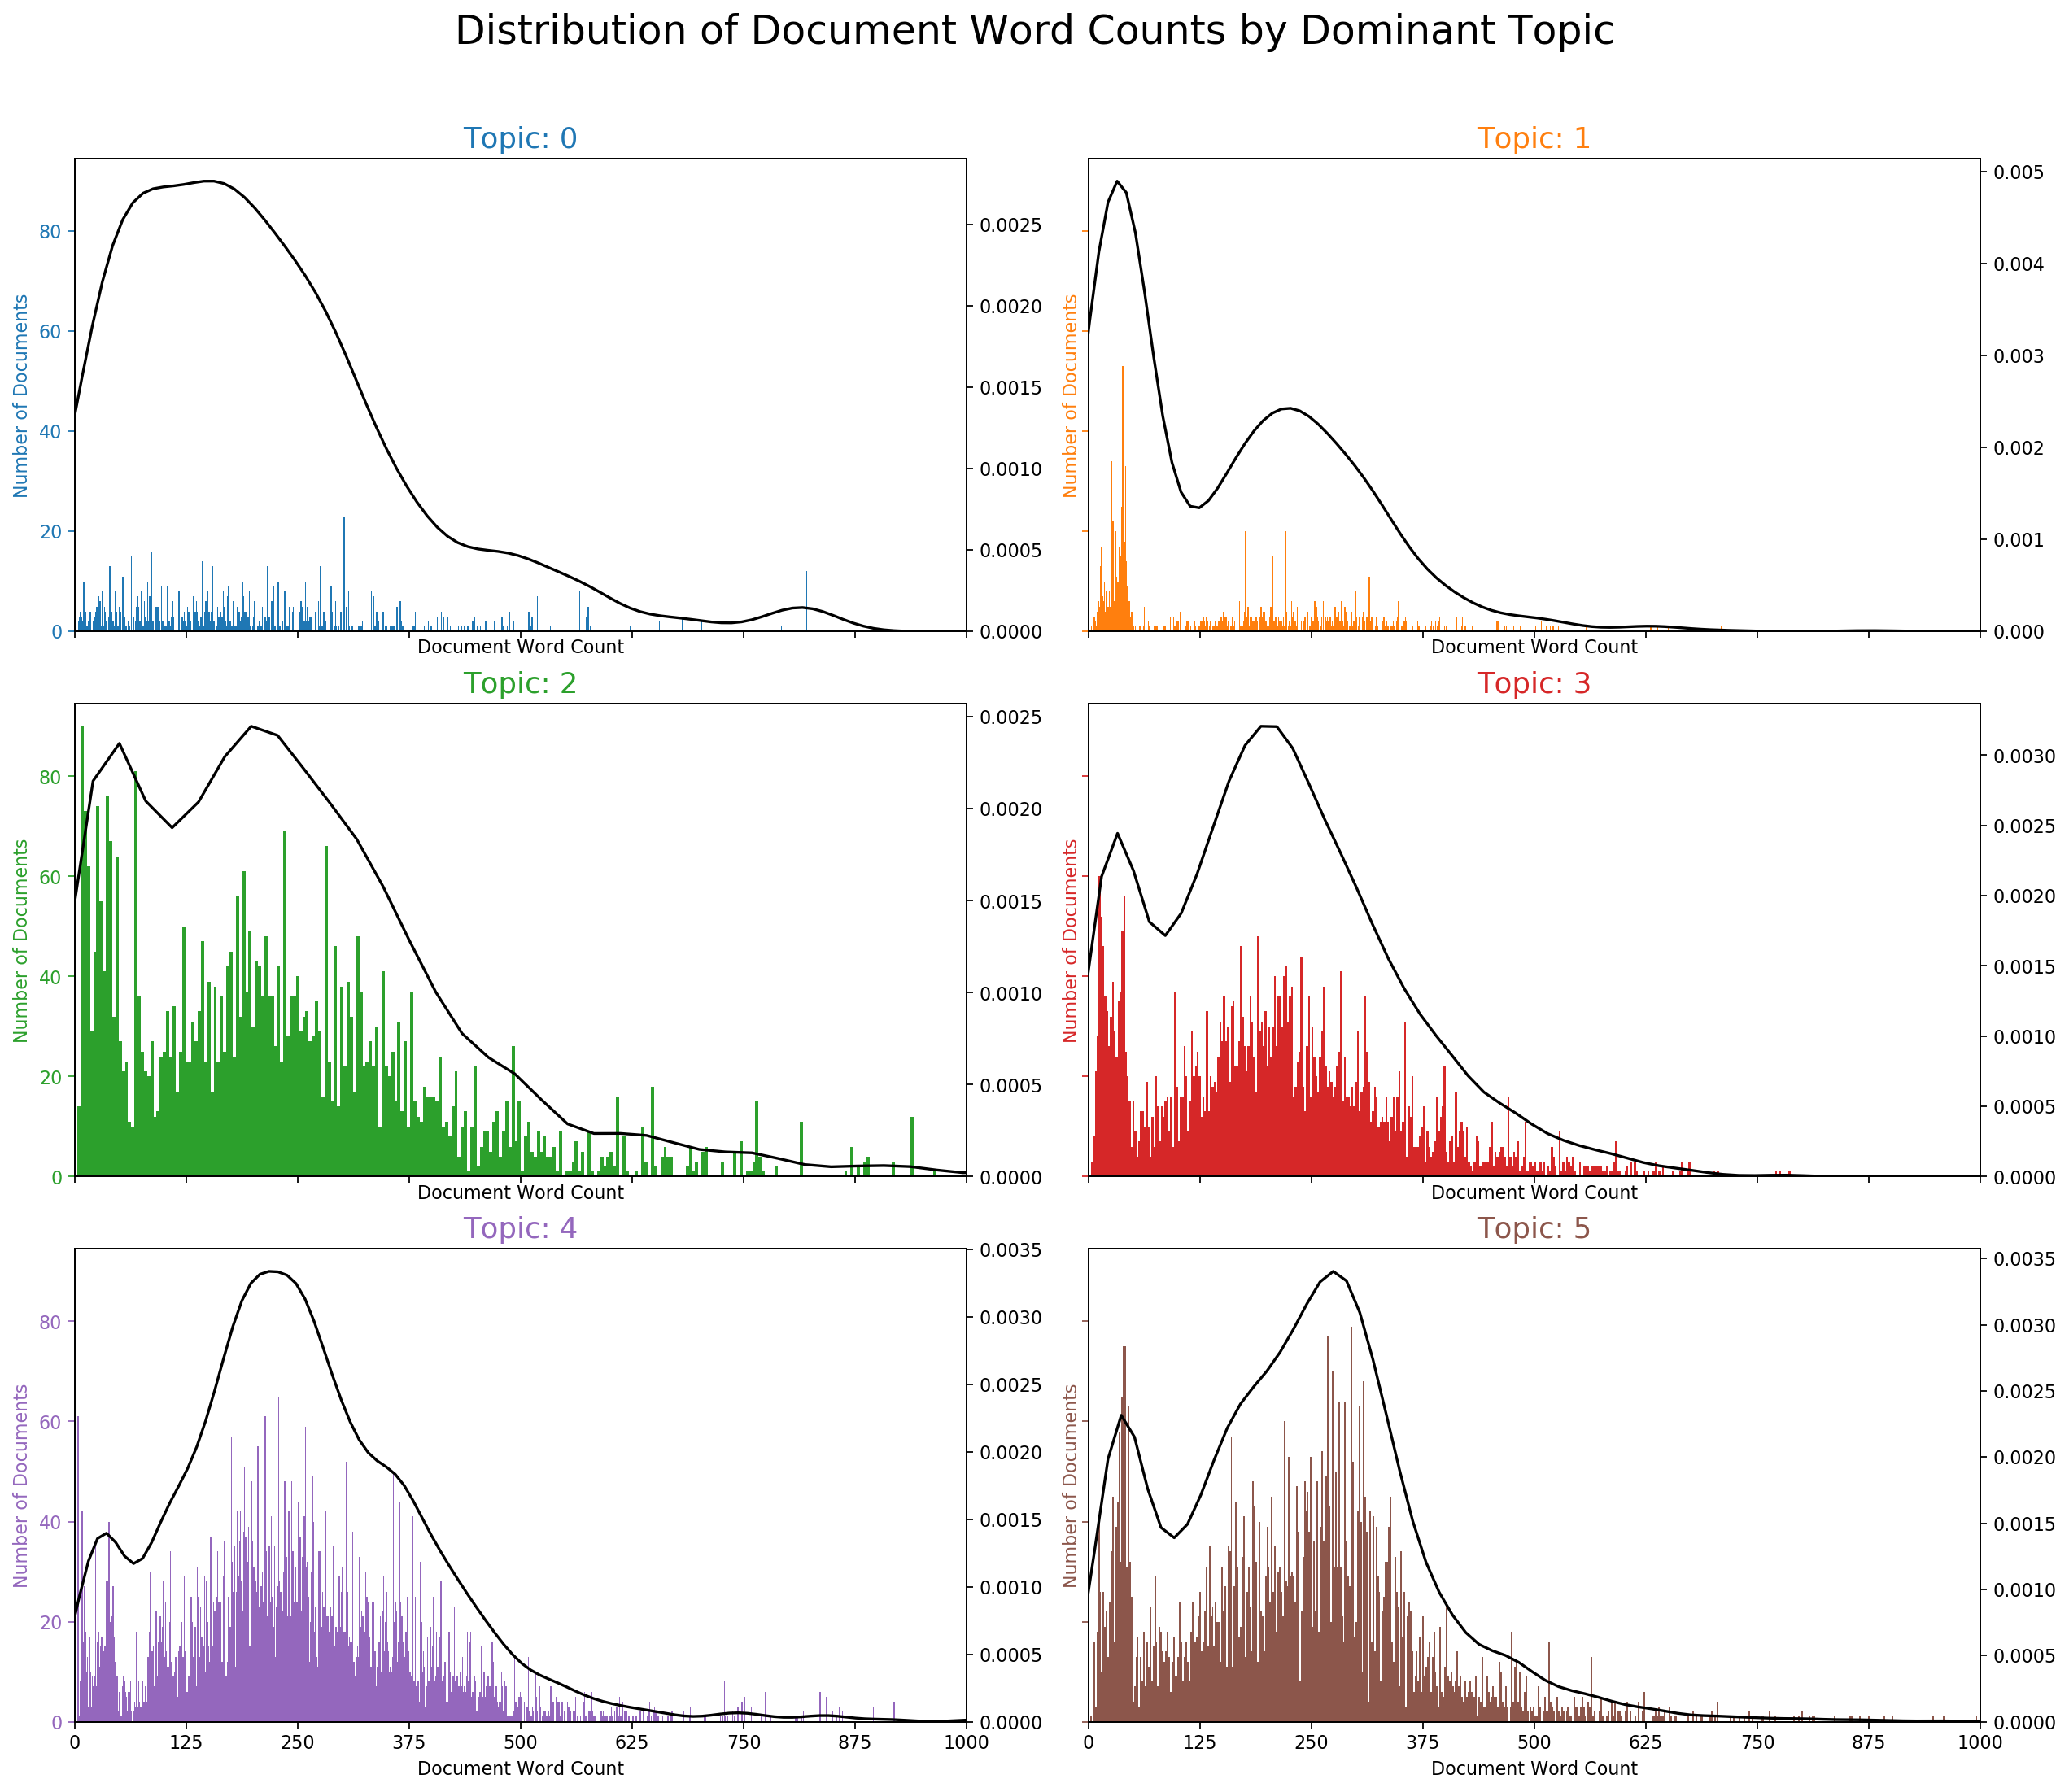

In [96]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

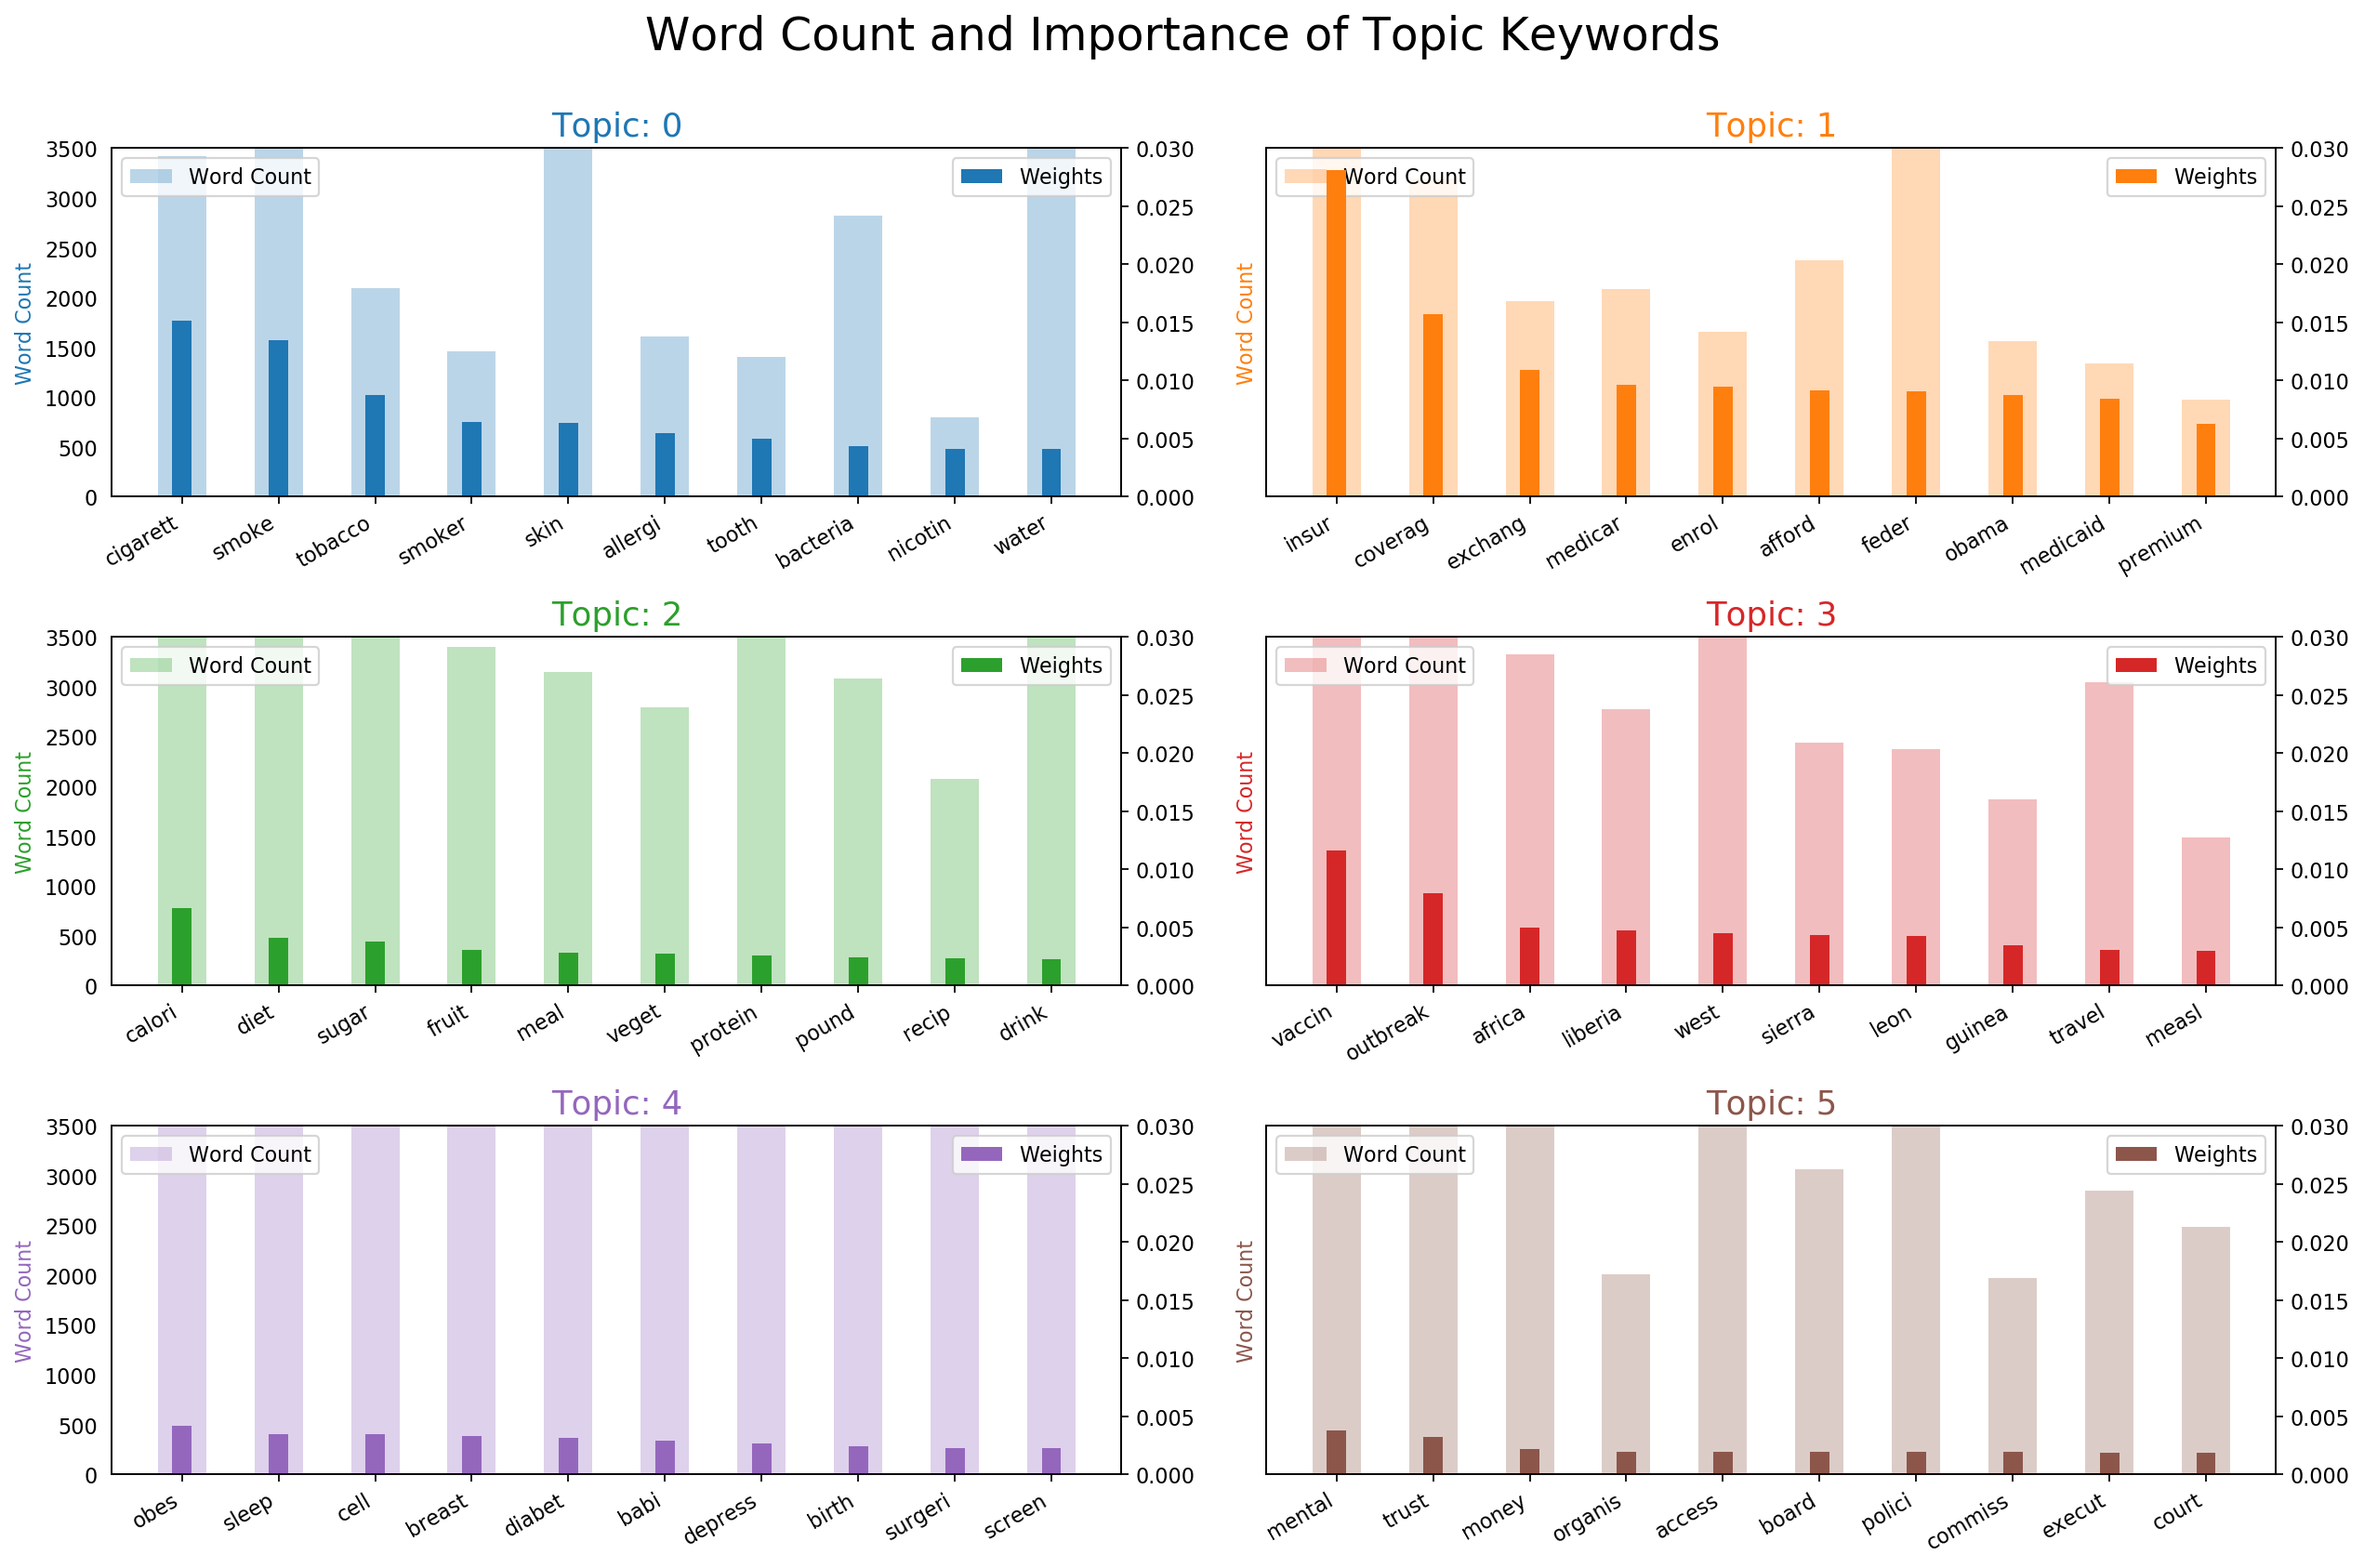

In [97]:
topics = lda_model_tfidf.show_topics(formatted=False)
data_flat = [w for w_list in processed_docs for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [98]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model_tfidf[bow_corpus]):
    topic_weights.append([w for i, w in enumerate(row_list[0])])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(E_TOPICS), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20489 samples in 0.092s...
[t-SNE] Computed neighbors for 20489 samples in 0.685s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20489
[t-SNE] Computed conditional probabilities for sample 2000 / 20489
[t-SNE] Computed conditional probabilities for sample 3000 / 20489
[t-SNE] Computed conditional probabilities for sample 4000 / 20489
[t-SNE] Computed conditional probabilities for sample 5000 / 20489
[t-SNE] Computed conditional probabilities for sample 6000 / 20489
[t-SNE] Computed conditional probabilities for sample 7000 / 20489
[t-SNE] Computed conditional probabilities for sample 8000 / 20489
[t-SNE] Computed conditional probabilities for sample 9000 / 20489
[t-SNE] Computed conditional probabilities for sample 10000 / 20489
[t-SNE] Computed conditional probabilities for sample 11000 / 20489
[t-SNE] Computed conditional probabilities for sample 12000 / 20489
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

### Saving Significant

In [94]:
# Save the Dict and Corpus
dictionary.save(dest_dictionary)  # save dictionary to disk
corpora.MmCorpus.serialize(dest_corpus, bow_corpus)  # save corpus to disk

# Save model
dill.dump(lda_model, open(dest_model,'wb'))
dill.dump(lda_model_tfidf, open(dest_model_tfidf, 'wb'))